In [1]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [3]:
# Load prepped data
finbert_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/04_Stock_Modeling/01_FinBERT_Prepped_Stock_Data.csv')
print(finbert_sentiment.shape)
display(finbert_sentiment.head())
print(finbert_sentiment.isna().sum())

(8084, 11)


,Article Index,Ticker,Source,Date,Article Headline,URL,Neutral,Positive,Negative,Sentiment,Returns
0,4890,BP,Investment Research,2019-02-20,Reaffirming BUY and $52 price target,NaN,0.360758,0.294953,0.344289,Neutral,0.002360
1,4882,BP,Investment Research,2019-05-06,Reiterating BUY and $52 price target,NaN,0.037869,0.626881,0.335249,Positive,-0.003482
2,7399,BP,ProQuest,2019-05-22,BP bosses get a public grilling on climate fro...,https://www.proquest.com/newspapers/bp-bosses-...,0.087031,0.219284,0.693685,Negative,-0.009591
3,7400,BP,ProQuest,2019-05-22,BP bosses get public grilling on climate from ...,https://www.proquest.com/newspapers/bp-bosses-...,0.090433,0.196855,0.712712,Negative,-0.009591
4,7398,BP,ProQuest,2019-05-23,Saudi Aramco starts fuel trading from UAE with...,https://www.proquest.com/newspapers/saudi-aram...,0.181392,0.017759,0.800849,Negative,-0.023618


Article Index          0
Ticker                 0
Source                 0
Date                   0
Article Headline       0
URL                 4444
Neutral                0
Positive               0
Negative               0
Sentiment              0
Returns                0
dtype: int64


In [4]:
# Drop extra columns
finbert_sentiment = finbert_sentiment.drop(['Article Headline','URL', 'Article Index'], axis=1)

# Convert the 'Date' column to datetime
finbert_sentiment['Date'] = pd.to_datetime(finbert_sentiment['Date'])
display(finbert_sentiment.head())

,Ticker,Source,Date,Neutral,Positive,Negative,Sentiment,Returns
0,BP,Investment Research,2019-02-20,0.360758,0.294953,0.344289,Neutral,0.002360
1,BP,Investment Research,2019-05-06,0.037869,0.626881,0.335249,Positive,-0.003482
2,BP,ProQuest,2019-05-22,0.087031,0.219284,0.693685,Negative,-0.009591
3,BP,ProQuest,2019-05-22,0.090433,0.196855,0.712712,Negative,-0.009591
4,BP,ProQuest,2019-05-23,0.181392,0.017759,0.800849,Negative,-0.023618


In [5]:
# One hot encode categorical variables
finbert_sentiment_encoded = pd.get_dummies(finbert_sentiment, columns=['Ticker', 'Source', 'Sentiment'], drop_first=True)
display(finbert_sentiment_encoded.head())

,Date,Neutral,Positive,Negative,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,...,Ticker_OXY,Ticker_PSX,Ticker_PXD,Ticker_SHEL,Ticker_TTE,Ticker_VLO,Ticker_XOM,Source_ProQuest,Sentiment_Neutral,Sentiment_Positive
0,2019-02-20,0.360758,0.294953,0.344289,0.002360,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,2019-05-06,0.037869,0.626881,0.335249,-0.003482,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2019-05-22,0.087031,0.219284,0.693685,-0.009591,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2019-05-22,0.090433,0.196855,0.712712,-0.009591,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2019-05-23,0.181392,0.017759,0.800849,-0.023618,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [6]:
# Split into test and train
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = finbert_sentiment_encoded[(finbert_sentiment_encoded['Date'] < split_date)]
test_df = finbert_sentiment_encoded[finbert_sentiment_encoded['Date'] >= split_date]

display(train_df.tail())
display(test_df.head())

,Date,Neutral,Positive,Negative,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,...,Ticker_OXY,Ticker_PSX,Ticker_PXD,Ticker_SHEL,Ticker_TTE,Ticker_VLO,Ticker_XOM,Source_ProQuest,Sentiment_Neutral,Sentiment_Positive
8011,2023-12-13,0.041624,0.533463,0.424913,0.008873,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
8012,2023-12-16,0.154809,0.254599,0.590593,-0.016701,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8013,2023-12-20,0.031745,0.691918,0.276336,-0.016701,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
8014,2023-12-23,0.185671,0.253178,0.561151,-0.012386,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8015,2023-12-30,0.155104,0.254590,0.590306,-0.012386,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


,Date,Neutral,Positive,Negative,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,...,Ticker_OXY,Ticker_PSX,Ticker_PXD,Ticker_SHEL,Ticker_TTE,Ticker_VLO,Ticker_XOM,Source_ProQuest,Sentiment_Neutral,Sentiment_Positive
715,2024-01-02,0.059805,0.010719,0.929476,0.002825,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
716,2024-01-06,0.286866,0.181357,0.531777,-0.015241,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
717,2024-01-09,0.115840,0.043042,0.841118,-0.015241,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
718,2024-01-11,0.051035,0.363417,0.585547,-0.002594,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
719,2024-01-13,0.284659,0.181449,0.533892,-0.016638,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# Define X and y
X_train = train_df.drop(columns=['Date','Returns'])
X_test = test_df.drop(columns=['Date','Returns'])

y_train = train_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test = test_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

print(len(X_train), len(y_train), len(X_test), len(y_test))
display(X_train.head())
display(y_train.head())

7568 7568 516 516


,Neutral,Positive,Negative,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,...,Ticker_OXY,Ticker_PSX,Ticker_PXD,Ticker_SHEL,Ticker_TTE,Ticker_VLO,Ticker_XOM,Source_ProQuest,Sentiment_Neutral,Sentiment_Positive
0,0.360758,0.294953,0.344289,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0.037869,0.626881,0.335249,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.087031,0.219284,0.693685,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,0.090433,0.196855,0.712712,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.181392,0.017759,0.800849,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


0    1
1    0
2    0
3    0
4    0
Name: Returns, dtype: int64

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.46      0.51       300
           1       0.42      0.55      0.48       216

    accuracy                           0.50       516
   macro avg       0.50      0.50      0.50       516
weighted avg       0.52      0.50      0.50       516



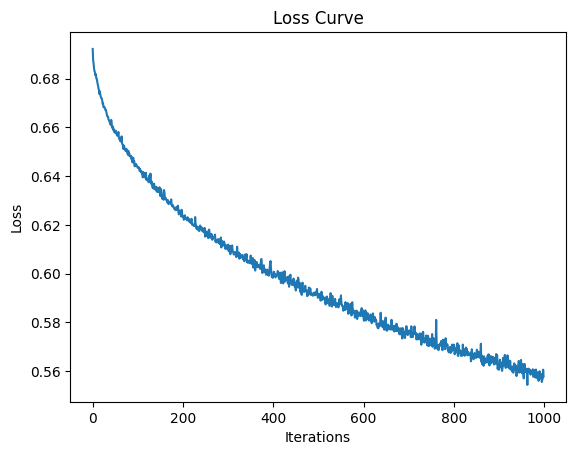

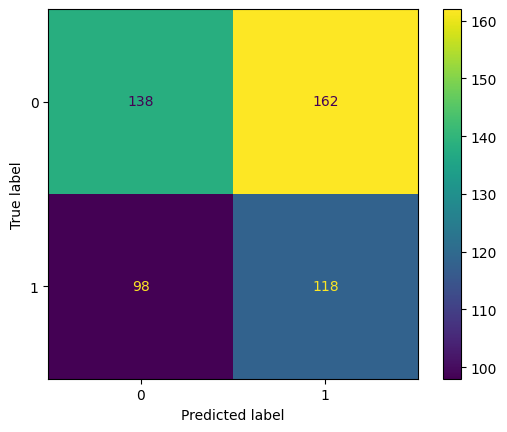

In [8]:
# Baseline MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    max_iter=1000,
    solver='adam',
    random_state=42,
    learning_rate='constant',
    learning_rate_init=0.001,
    early_stopping=False,
    tol = 1e-8,
    n_iter_no_change = 100)

# Train the model
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': [32, 16], 'solver': 'adam'}
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       300
           1       0.41      0.51      0.46       216

    accuracy                           0.49       516
   macro avg       0.49      0.49      0.49       516
weighted avg       0.51      0.49      0.49       516



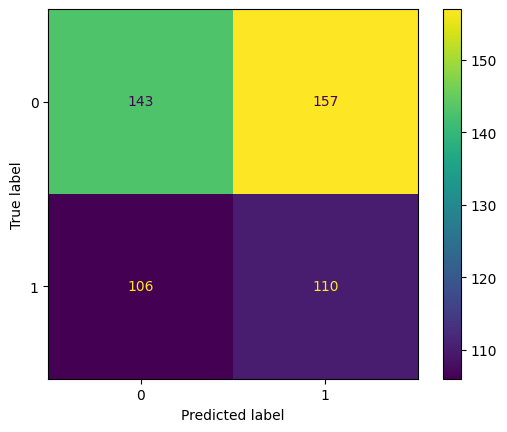

In [9]:
# Tuned MLP classifier

# Define the parameter grid
param_grid = {
    "hidden_layer_sizes": [
        [16, 8, 4, 2],
        [16, 8, 4],
        [8, 4, 2],
        [32, 16],
        [16, 8],
        [16, 4]
    ],
    "activation": ['logistic', 'tanh', 'relu'],
    "alpha": [0.001, 0.01, 0.1],
    "solver": ['adam']
}

# Create an MLP Forest classifier
mlp = MLPClassifier(max_iter=500)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [10]:
# Since dates can have multiple articles and therefore multiple predictions, we can
# pick the result with the highest probability.  This might be important for the next steps,
# but currently this is just a placeholder

# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(X_test, columns=X_test.columns)
results_df['Actual'] = y_test
results_df['Predicted_Class'] = y_pred
results_df['Predicted_Probability_Class_0'] = y_pred_proba[:, 0]
results_df['Predicted_Probability_Class_1'] = y_pred_proba[:, 1]
display(results_df.head())

,Neutral,Positive,Negative,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,...,Ticker_TTE,Ticker_VLO,Ticker_XOM,Source_ProQuest,Sentiment_Neutral,Sentiment_Positive,Actual,Predicted_Class,Predicted_Probability_Class_0,Predicted_Probability_Class_1
715,0.059805,0.010719,0.929476,False,False,False,False,False,False,False,...,False,False,False,True,False,False,1,0,0.563439,0.436561
716,0.286866,0.181357,0.531777,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0,0,0.514068,0.485932
717,0.115840,0.043042,0.841118,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0,0,0.566320,0.433680
718,0.051035,0.363417,0.585547,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0,1,0.419806,0.580194
719,0.284659,0.181449,0.533892,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0,0,0.513550,0.486450
